In [28]:
import fitz
import matplotlib.pyplot as plt

points_table_pdf = fitz.open("C:\\Users\\tbwil\\Documents\\Projects\\IAAF_Points\\world_athletics_points_table_outdoor2022.pdf")

1351 
 - 
[1400.0, 1399.0, 1398.0, 1397.0, 1396.0, 1395.0, 1394.0, 1393.0, 1392.0, 1391.0, 1390.0, 1389.0, 1388.0, 1387.0, 1386.0, 1385.0, 1384.0, 1383.0, 1382.0, 1381.0, 1380.0, 1379.0, 1378.0, 1377.0, 1376.0, 1375.0, 1374.0, 1373.0, 1372.0, 1371.0, 1370.0, 1369.0, 1368.0, 1367.0, 1366.0, 1365.0, 1364.0, 1363.0, 1362.0, 1361.0, 1360.0, 1359.0, 1358.0, 1357.0, 1356.0, 1355.0, 1354.0, 1353.0, 1352.0, 1351.0, None]
[9.46, None, None, None, 9.47, None, None, None, 9.48, None, None, 9.49, None, None, None, 9.5, None, None, None, 9.51, None, None, 9.52, None, None, None, 9.53, None, None, None, 9.54, None, None, 9.55, None, None, None, 9.56, None, None, None, 9.57, None, None, 9.58, None, None, None, 9.59, None, None]


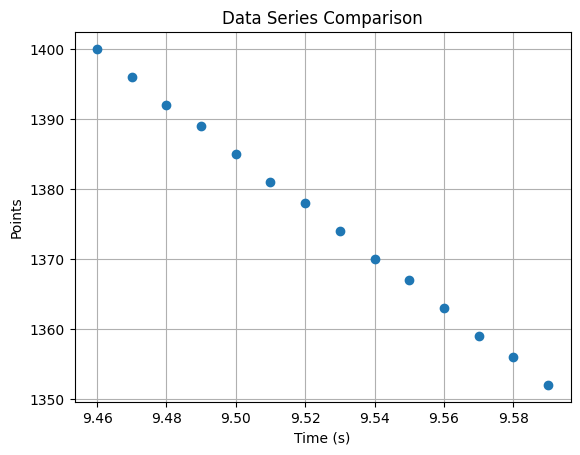

In [45]:
page = points_table_pdf[8].get_text()
rows = page.split('\n')
points = []
OM100m = []
for i in range(len(rows)):
    if((i-2)%11 == 0):
        points.append(rows[i])
    if((i-3)%11 == 0):
        OM100m.append(rows[i])
print(points[-2])
print(OM100m[-2])
points = points[1:50]
OM100m = OM100m[1:50]

points = [float(value) if (value.strip() != '-' and value.strip() != '') else None for value in points]
OM100m = [float(value) if (value.strip() != '-' and value.strip() != '') else None for value in OM100m]

print(points)
print(OM100m)

plt.plot(OM100m, points, marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Points')
plt.title('Data Series Comparison')
plt.grid(True)

# Display the plot
plt.show()

In [52]:
page = points_table_pdf[9].get_text()
rows = page.split('\n')
points = []
OM100m = []
for i in range(len(rows)):
    if((i-1)%11 == 0 and i > 1):
        points.append(rows[i])
    if((i-2)%11 == 0):
        OM100m.append(rows[i])
print(points)
print(OM100m)
print(page)

['Points ', '1350 ', '1349 ', '1348 ', '1347 ', '1346 ', '1345 ', '1344 ', '1343 ', '1342 ', '1341 ', '1340 ', '1339 ', '1338 ', '1337 ', '1336 ', '1335 ', '1334 ', '1333 ', '1332 ', '1331 ', '1330 ', '1329 ', '1328 ', '1327 ', '1326 ', '1325 ', '1324 ', '1323 ', '1322 ', '1321 ', '1320 ', '1319 ', '1318 ', '1317 ', '1316 ', '1315 ', '1314 ', '1313 ', '1312 ', '1311 ', '1310 ', '1309 ', '1308 ', '1307 ', '1306 ', '1305 ', '1304 ', '1303 ', '1302 ', '1301 ']
['100m ', '  - ', '  - ', ' 9.60 ', '  - ', '  - ', ' 9.61 ', '  - ', '  - ', '  - ', ' 9.62 ', '  - ', '  - ', '  - ', ' 9.63 ', '  - ', '  - ', ' 9.64 ', '  - ', '  - ', '  - ', ' 9.65 ', '  - ', '  - ', '  - ', ' 9.66 ', '  - ', '  - ', ' 9.67 ', '  - ', '  - ', '  - ', ' 9.68 ', '  - ', '  - ', ' 9.69 ', '  - ', '  - ', '  - ', ' 9.70 ', '  - ', '  - ', '  - ', ' 9.71 ', '  - ', '  - ', ' 9.72 ', '  - ', '  - ', '  - ', ' 9.73 ', ' ']
MEN’S SPRINTS, HURDLES AND RELAYS / HOMMES SPRINTS, HAIES ET RELAIS 
3 
100m 
200m 
300m 
400m 

In [53]:
points = []
event = []
for page_num in range(8,35):
    points_batch = []
    event_batch = []
    page = points_table_pdf[page_num].get_text()
    rows = page.split('\n')
    page_odd = page_num % 2
    for i in range(2,len(rows)):
        if((i - 2 + page_odd) % 11 == 0):
            points_batch.append(rows[i])
        if((i - 3 + page_odd) % 11 == 0):
            event_batch.append(rows[i])
    points = points + points_batch[1:51]
    event = event + event_batch[1:51]
print(points)

['1400 ', '1399 ', '1398 ', '1397 ', '1396 ', '1395 ', '1394 ', '1393 ', '1392 ', '1391 ', '1390 ', '1389 ', '1388 ', '1387 ', '1386 ', '1385 ', '1384 ', '1383 ', '1382 ', '1381 ', '1380 ', '1379 ', '1378 ', '1377 ', '1376 ', '1375 ', '1374 ', '1373 ', '1372 ', '1371 ', '1370 ', '1369 ', '1368 ', '1367 ', '1366 ', '1365 ', '1364 ', '1363 ', '1362 ', '1361 ', '1360 ', '1359 ', '1358 ', '1357 ', '1356 ', '1355 ', '1354 ', '1353 ', '1352 ', '1351 ', '1350 ', '1349 ', '1348 ', '1347 ', '1346 ', '1345 ', '1344 ', '1343 ', '1342 ', '1341 ', '1340 ', '1339 ', '1338 ', '1337 ', '1336 ', '1335 ', '1334 ', '1333 ', '1332 ', '1331 ', '1330 ', '1329 ', '1328 ', '1327 ', '1326 ', '1325 ', '1324 ', '1323 ', '1322 ', '1321 ', '1320 ', '1319 ', '1318 ', '1317 ', '1316 ', '1315 ', '1314 ', '1313 ', '1312 ', '1311 ', '1310 ', '1309 ', '1308 ', '1307 ', '1306 ', '1305 ', '1304 ', '1303 ', '1302 ', '1301 ', '1300 ', '1299 ', '1298 ', '1297 ', '1296 ', '1295 ', '1294 ', '1293 ', '1292 ', '1291 ', '1290 ', 

Plan is to extract the data from the pdf file and write it as a json so the computation only has to be done once.